
# Pure Mann Model Fit

This example demonstrates the a simple configuration of ``DRDMannTurb`` to spectra fitting while using the Mann model as the eddy lifetime function under the Kaimal one-point spectra.

For reference, the full Mann eddy lifetime function is given by 

\begin{align}\tau^{\mathrm{IEC}}(k)=\frac{(k L)^{-\frac{2}{3}}}{\sqrt{{ }_2 F_1\left(1 / 3,17 / 6 ; 4 / 3 ;-(k L)^{-2}\right)}}\end{align}

and the Kaimal one-point spectra. This set of models has classically been most useful for flat homogeneous terrains. 

Also, the resulting fitting can be used directly to generate a 3D Mann fluctuation field, as demonstrated in our wind generation example. 


## Import packages

First, we import the packages we need for this example.



In [1]:
import torch

from drdmannturb import EddyLifetimeType
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

# v2: torch.set_default_device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

Set up physical parameters and domain associated with the Kaimal spectrum. We perform the spectra fitting over the $k_1$ space :math:[10^{{-1}}, 10^2]`
with 20 points.



In [2]:
# Scales associated with Kaimal spectrum
L = 0.59  # length scale
Gamma = 3.9  # time scale
sigma = 3.2  # energy spectrum scale

domain = torch.logspace(-1, 2, 20)

## ``CalibrationProblem`` Construction
The following cell defines the ``CalibrationProblem`` using default values
for the ``NNParameters`` and ``LossParameters`` dataclasses. Importantly,
these data classes are not necessary, see their respective documentations for the default values.
The current set-up involves using the Mann model for the eddy lifetime function, meaning no
neural network is used in learning the $\tau$ function. Additionally, the physical parameters
are taken from the reference values for the Kaimal spectra. Finally, in this scenario the regression
occurs as an MSE fit to the spectra, which are generated from Mann turbulence (i.e. a synthetic data fit).
The ``EddyLifetimeType.MANN`` argument determines the type of eddy lifetime function to use.



In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(),
    prob_params=ProblemParameters(eddy_lifetime=EddyLifetimeType.MANN, nepochs=2),
    loss_params=LossParameters(),
    phys_params=PhysicalParameters(L=L, Gamma=Gamma, sigma=sigma, domain=domain),
    device=device,
)

## Data Generation
The following cell generates the dataset required for calibration.

The first two lines are required to construct the spatial grid of points.
Specifically, ``DataPoints`` is a list of tuples of the observed spectra data
points at each of the $k_1$
coordinates and the reference height (in our case, this is just $1$).

Lastly, we collect ``Data = (<data points>, <data values>)`` to be used in calibration.



In [4]:
k1_data_pts = domain
DataPoints = [(k1, 1) for k1 in k1_data_pts]

Data = OnePointSpectraDataGenerator(data_points=DataPoints).Data

The model is now "calibrated" to the provided spectra from the synthetic
data generated from ``OnePointSpectraDataGenerator``.

The Mann eddy lifetime function relies on evaluating a hypergeometric function,
which only has a CPU implementation through ``Scipy``. When using this function
with a neural network task, consider either learning this function as well or
using a linear approximation from your data that provides a GPU kernel for
fast evaluation of a similar model. See a later example.

Having the necessary components, the model is "calibrated" (fit) to the provided spectra
and we conclude with a plot.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

Initial loss: 0.09375912098796542


  0%|                                                                                           | 0/2 [00:00<?, ?it/s]

 50%|█████████████████████████████████████████▌                                         | 1/2 [00:04<00:04,  4.37s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.45s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.59s/it]

Spectra fitting concluded with final loss: 0.032209544120698506


The following plot shows the best fit to the synthetic Mann data. Notice that
the eddy lifetime function is precisely the Mann model.



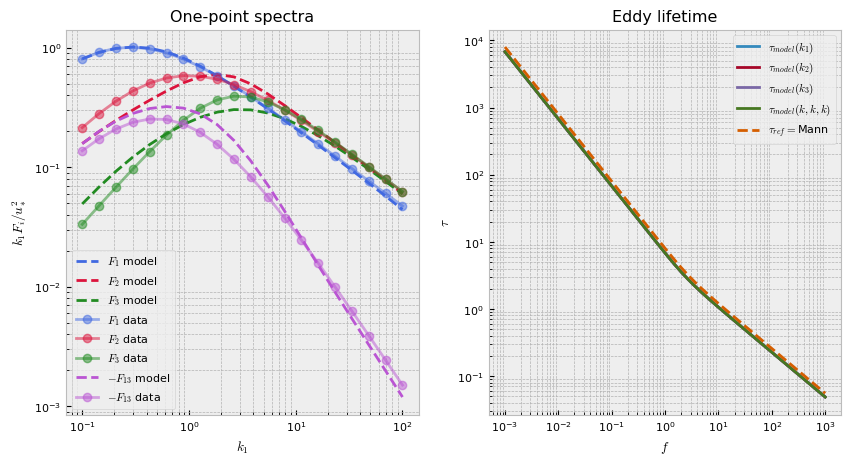

In [6]:
pb.plot()